In [1]:
import numpy as np
#from scipy.interpolate import RectBivariateSpline
import scipy.interpolate as interpolate
import datetime as dt
import os
from copy import deepcopy as cp
import netCDF4 as nc
import sys
from dask import delayed
import matplotlib
import matplotlib.pyplot as plt
#import warnings
# Import writer class from csv module
from csv import writer
import xarray as xr

In [2]:
#SCENARIO_COMBNATION = ['frst-ctl','crop-ctl']
SCENARIO_COMBNATION = ['crop-ctl','frst-ctl','irri-crop']
scenario_title=['CROP-CTL','FRST-CTL','IRR-CROP']
# MODEL = ['mpiesm', 'cesm', 'ecearth'] #, "cesm" "ecearth" "mpiesem"
# CMOR_TABLE="Eyr"  # "Lmon" "LImon" "Emon" "Lmon" "Eyr" "Lmon"; choose "cesm" for all cesm variables as they are currently stored in /scratch/b/b380948/signal_separation/cesm_output/
# CMOR_VAR_table=['tas', 'tas-distribution', 'cLand'] #ah cesm model output data used with cesm table
region_list= ['50s','40s','30s','20s','10s','tro','10n','20n','30n','40n','50n','60n','70n']
#SCENARIO_COMBNATION = ['frst-ctl']
#region_list= ['NAM']
number=['a','b','c']

3
<generator object <genexpr> at 0x7fff98796f80>
3
<generator object <genexpr> at 0x7fff98796f80>
3
<generator object <genexpr> at 0x7fff98796f80>


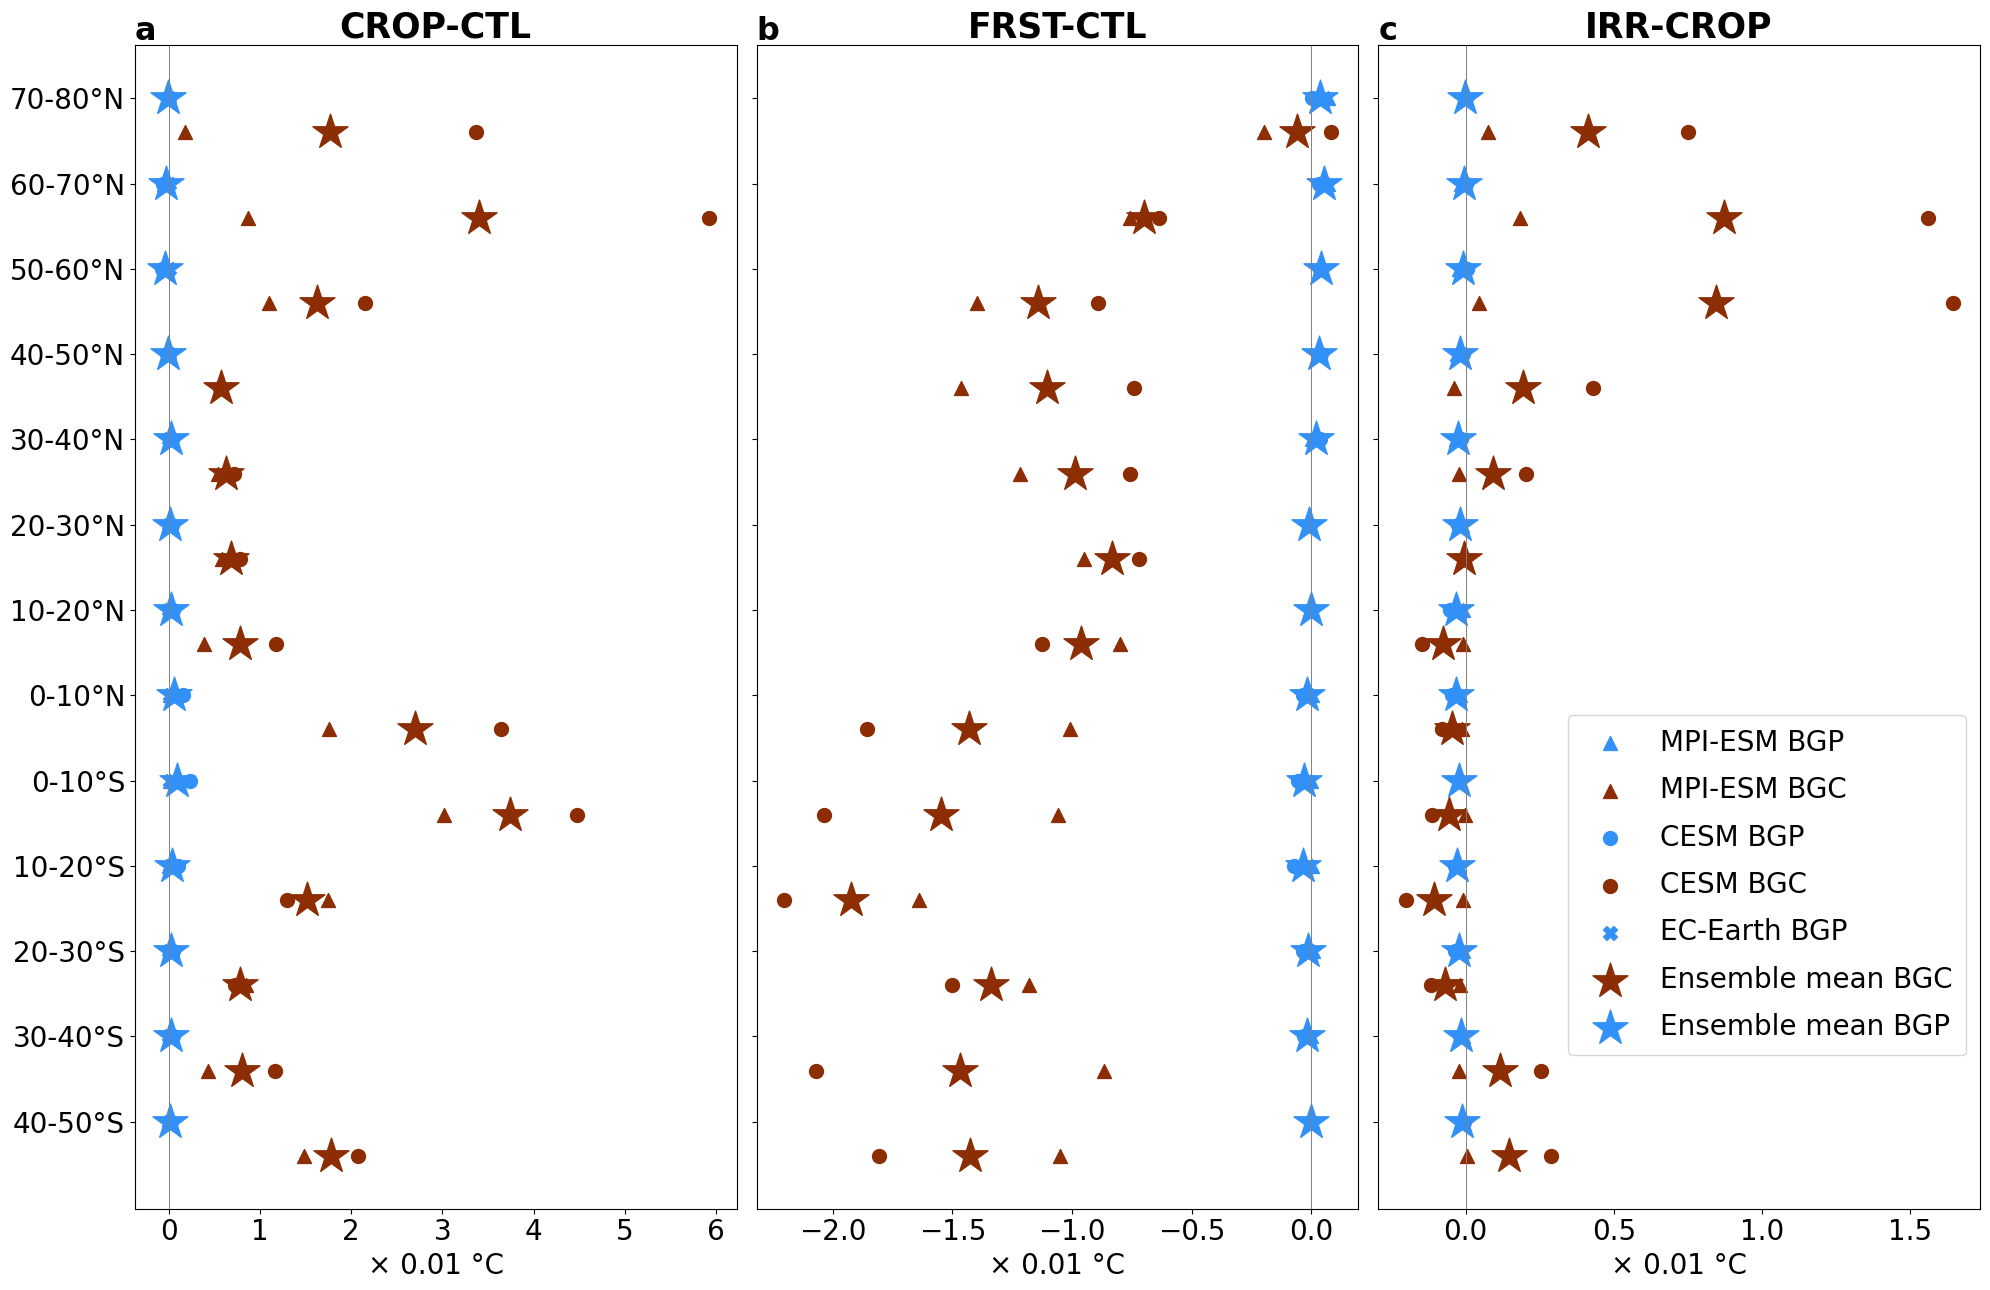

In [3]:
colors = ['#3291F8', '#8C2D04']
labels = ['local\nBGP', 'local\nBGC']
# Create a figure with 3 subplots in one row
fig, axes = plt.subplots(1, 3, figsize=(20, 13))
# Loop over each scenario and region to plot data
y1= [0,2.5,5,7.5,10,12.5,15,17.5,20,22.5,25,27.5,30]
y2= [1,3.5,6,8.5,11,13.5,16,18.5,21,23.5,26,28.5,31]
for i, SCENARIO in enumerate(SCENARIO_COMBNATION):
    mpiesm_BGC_value = []
    mpiesm_BGP_value = []
    cesm_BGC_value = []
    cesm_BGP_value = []
    ecearth_BGP_value = []
    ensemble_BGP_arr  = []
    ensemble_BGC_arr = []
    for j, region_source in enumerate(region_list):

        mpiesm_cland_dir_GHG_onglobal = xr.open_dataset('/work/bm1147/b380949/web-monitoring/MPI-PLOT/Lutdata/TCRE/latitudemean/' + region_source + \
        '/tas_fldmean_' + SCENARIO + '_mpiesm_Lut_last30mean_chname_' + region_source + '_' + 'GLOBAL' + '.nc')

        mpiesm_bgp_dir_tas = xr.open_dataset('/work/bm1147/b380949/web-monitoring/MPI-PLOT/climate/latitudemean/' + \
        'tas_fldmean_' + SCENARIO + '_mpiesm_ensmean_signal-separated_' + region_source + '.nc')
        
        cesm_cland_dir_GHG_onglobal = xr.open_dataset('/work/bm1147/b380949/web-monitoring/CESM/plot/final_Lunit/RTCRE_regional/latitudemean/' + region_source + \
        '/tas_fldmean_' + SCENARIO + '_cesm_Lut_last30mean_chname_' + region_source + '_GLOBAL' + '.nc')
        #x = [-40,-30,-20,-10,0,10,20,30,40]        #-37~37
        
        if SCENARIO == 'irri-crop':

            cesm_bgp_dir_tas = xr.open_dataset('/work/bm1147/b380949/web-monitoring/CESM/plot/harv_cli/final/latitudemean/' + \
                                               '/TREFHT_fldmean_irr-crop_cesm_ensmean_signal-separated_'  + region_source + '.nc')
            ecearth_bgp_dir_tas = xr.open_dataset('/work/bm1147/b380949/web-monitoring/ecearth_plot/climate/latitudemean/' + \
                                              '/2t_fldmean_irr-crop_ecearth_ensmean_signal-separated_'  + region_source + '_chname.nc')
        else:
            cesm_bgp_dir_tas = xr.open_dataset('/work/bm1147/b380949/web-monitoring/CESM/plot/harv_cli/final/latitudemean/' + \
                                           '/TREFHT_fldmean_' + SCENARIO + '_cesm_ensmean_signal-separated_'  + region_source + '.nc')
            ecearth_bgp_dir_tas = xr.open_dataset('/work/bm1147/b380949/web-monitoring/ecearth_plot/climate/latitudemean/' + \
                                              '/2t_fldmean_' + SCENARIO + '_ecearth_ensmean_signal-separated_'  + region_source + '_chname.nc')
        
        
        if SCENARIO == 'irri-crop' or SCENARIO == 'frst-ctl':
            ecearth_BGP = [np.nan]
            ecearth_BGP_value.append(ecearth_BGP)
        else:
            ecearth_BGP = [100 * ( ecearth_bgp_dir_tas.tas_local.values[0][0][0]/510 )]
            ecearth_BGP_value.append(ecearth_BGP)
             
        mpiesm_BGC = [100 * mpiesm_cland_dir_GHG_onglobal.tas_local.values[0][0][0]]
        mpiesm_BGP = [100 * (mpiesm_bgp_dir_tas.tas_local.values[0][0][0]/510)]
        # Append the current mpiesm to the list of values
        mpiesm_BGC_value.append(mpiesm_BGC)
        mpiesm_BGP_value.append(mpiesm_BGP)
        cesm_BGP = [100 * ( cesm_bgp_dir_tas.TREFHT_local.values[0][0][0]/510 )]
        cesm_BGC = [100 * cesm_cland_dir_GHG_onglobal.tas_local.values[0][0][0]]
        cesm_BGP_value.append(cesm_BGP)
        cesm_BGC_value.append(cesm_BGC)

    ensemble_BGP_arr = [cesm_BGP_value, mpiesm_BGP_value, ecearth_BGP_value]
    ensemble_BGP = np.nanmean(ensemble_BGP_arr, axis=0)          
    ensemble_BGC_arr = [cesm_BGC_value, mpiesm_BGC_value]
    ensemble_BGC = np.nanmean(ensemble_BGC_arr, axis=0)
    ax = axes[i]
    print(len(ensemble_BGP_arr))
    print(ensemble_BGP_arr[0] for model_values in ensemble_BGP_arr)

    ax.scatter(mpiesm_BGP_value, y2, marker='^', s=100, color='#3291F8', label='MPI-ESM BGP')
    ax.scatter(mpiesm_BGC_value, y1, marker='^', s=100, color='#8C2D04', label='MPI-ESM BGC')    
    ax.scatter(cesm_BGP_value, y2, marker='o', s=100, color='#3291F8', label='CESM BGP')
    ax.scatter(cesm_BGC_value, y1, marker='o', s=100, color='#8C2D04', label='CESM BGC') 
    ax.scatter(ecearth_BGP_value, y2, marker='X', s=100, color='#3291F8', label='EC-Earth BGP')
    ax.scatter(ensemble_BGC, y1, marker='*', s=700,color='#8C2D04', label='Ensemble mean BGC') 
    ax.scatter(ensemble_BGP, y2,marker='*', s=700, color='#3291F8', label='Ensemble mean BGP')
    
    ax.set_title(scenario_title[i], fontsize=25,fontweight='bold')
    ax.text(0.00, 1.025,number[i] , fontsize=23, rotation=0,fontweight='bold',
         verticalalignment='top', horizontalalignment='left', transform=ax.transAxes)
    #ax.axhline(0, color='grey', linewidth=0.7)
    ax.axvline(0, color='grey', linewidth=0.7)
    # Update the Y-axis label to reflect the new scale
    ax.set_xlabel('× 0.01 °C', fontsize=20)
    labels = ['40-50°S', '30-40°S', '20-30°S', '10-20°S', '0-10°S', '0-10°N', '10-20°N', '20-30°N', '30-40°N', '40-50°N', '50-60°N', '60-70°N', '70-80°N']
    if SCENARIO == 'crop-ctl':
        ax.set_yticks(y2)
        ax.set_yticklabels(labels, fontsize=20)
        ax.tick_params(axis='x', labelsize=20)
    else: 
        label_none= [None] * 13
        ax.set_yticks(y2)
        ax.set_yticklabels(label_none, fontsize=20)
        ax.tick_params(axis='x', labelsize=20)
plt.subplots_adjust(wspace=None, hspace=None)
plt.tight_layout()
#ax.legend(loc='lower right', fontsize=20, markerscale=1.5)
# ax.legend(loc='lower right', fontsize=20, markerscale=1.5, 
          # borderpad=1.5, handletextpad=2, labelspacing=1.5, 
          # borderaxespad=1.0) 
# borderpad=1.5: Increases the padding inside the legend box.
# handletextpad=2: Increases the space between the marker and the label text.
# labelspacing=1.5: Increases the vertical space between the legend elements.
# borderaxespad=1.0: Adds padding between the legend box and the axes.
ax.legend(loc='lower right', fontsize=20, markerscale=1, 
          borderpad=0.5, labelspacing=0.7, 
          borderaxespad=0.5, bbox_to_anchor=(1, 0.12)) 
# bbox_to_anchor=(1, 0.8): This argument moves the legend's anchor point. The first value (1) is the x-coordinate (relative to the axes, with 1 being the far right)
# and the second value (0.8) is the y-coordinate (with 0 being the bottom and 1 being the top).


# Save the entire figure
#plt.savefig('/work/bm1147/b380949/web-monitoring/secP/supplement_lat-contrib2global/FigS7_lat-contrib2global-nodata.jpg', format='jpg')
plt.savefig('/scratch/b/b380949/NC-FigS7_lat-contrib2global-nodata.pdf', format='pdf')

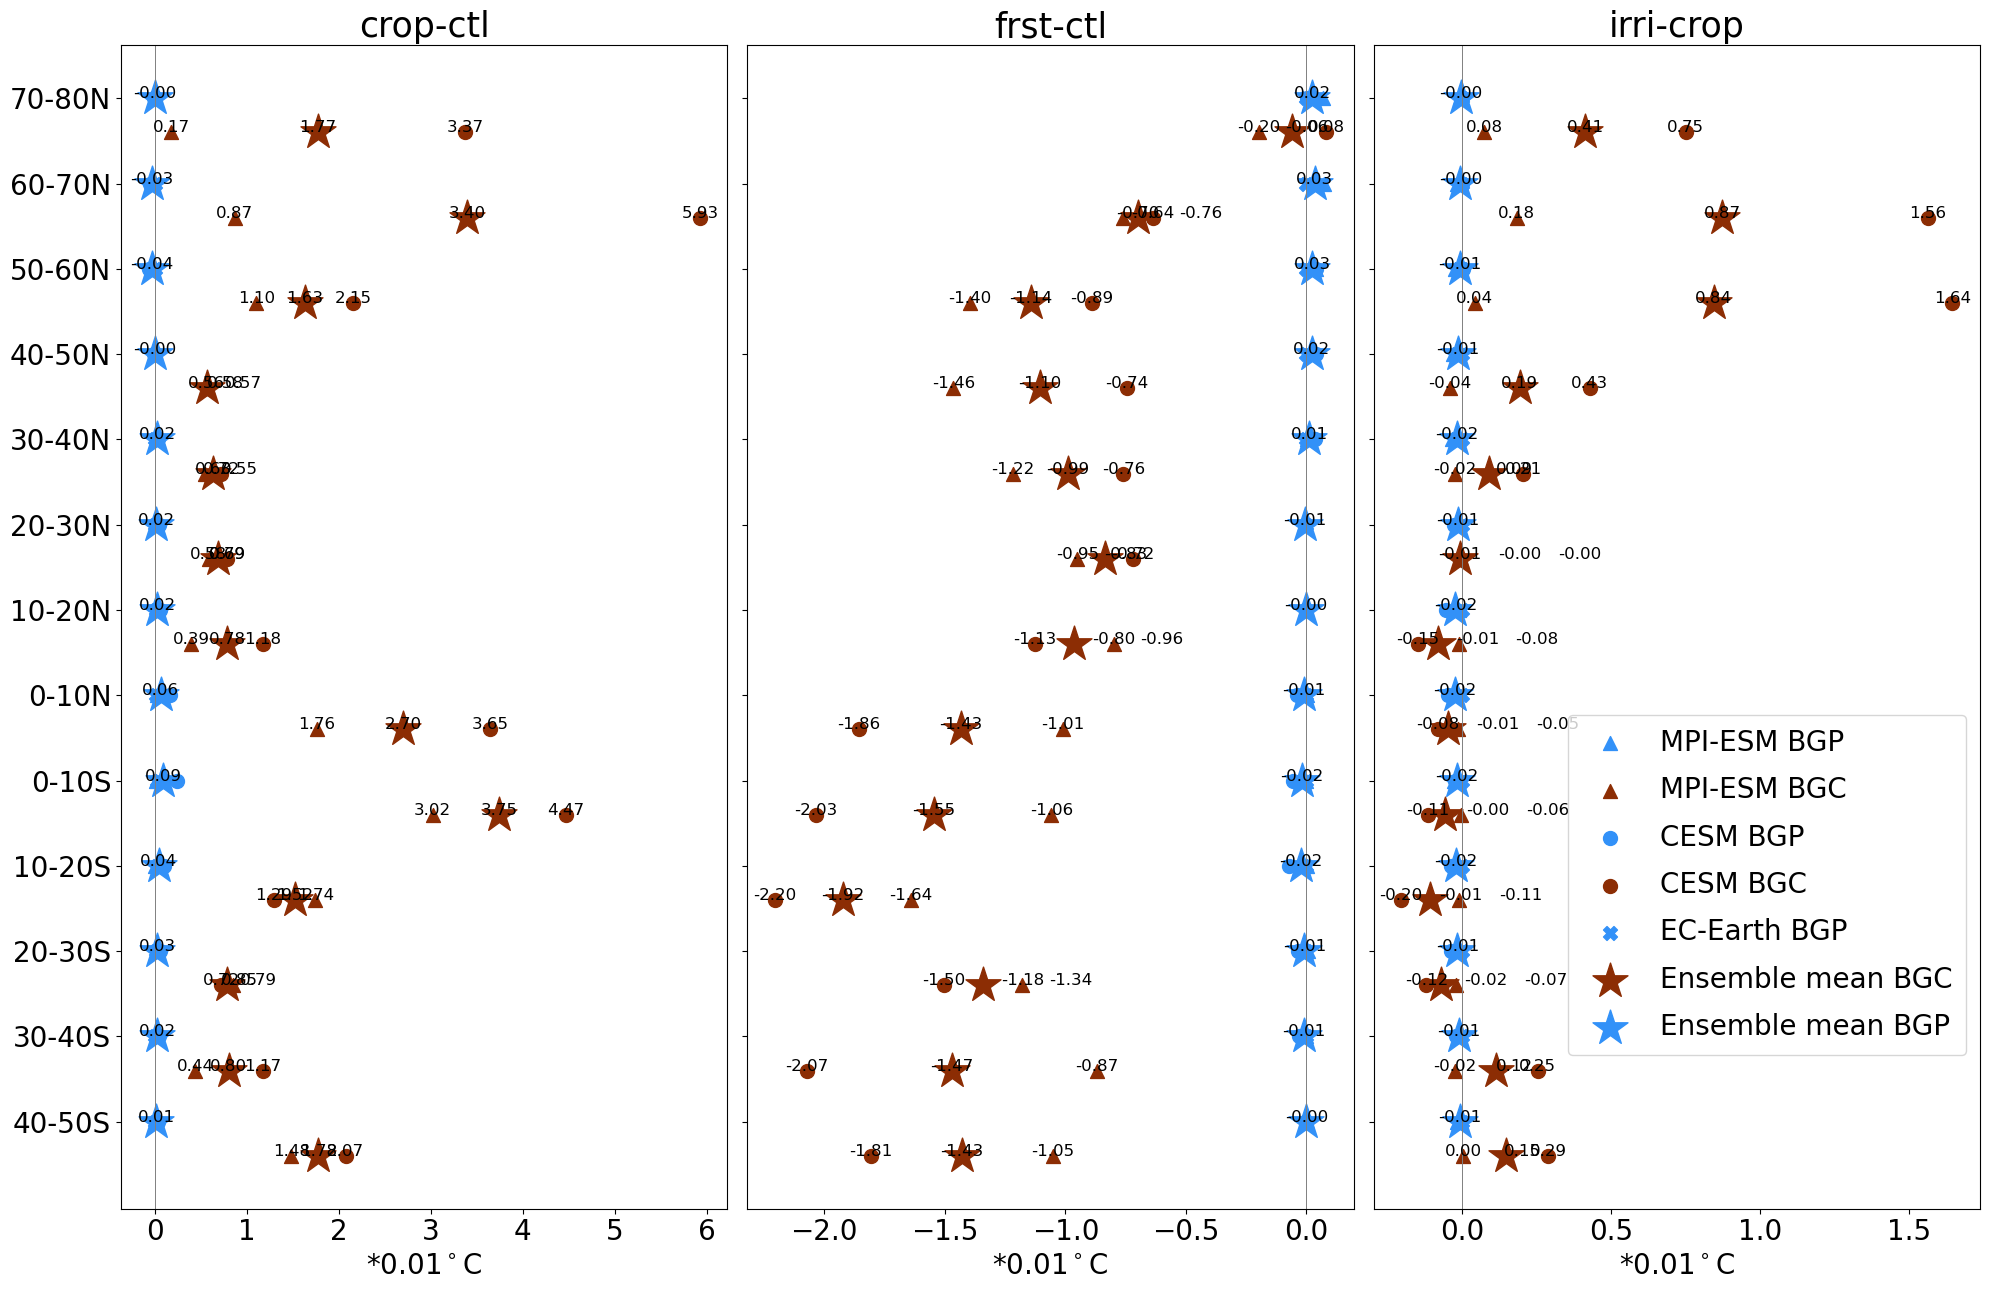

In [27]:
colors = ['#3291F8', '#8C2D04']
labels = ['local\nBGP', 'local\nBGC']
# Create a figure with 3 subplots in one row
fig, axes = plt.subplots(1, 3, figsize=(20, 13))
# Loop over each scenario and region to plot data
y1= [0,2.5,5,7.5,10,12.5,15,17.5,20,22.5,25,27.5,30]
y2= [1,3.5,6,8.5,11,13.5,16,18.5,21,23.5,26,28.5,31]
for i, SCENARIO in enumerate(SCENARIO_COMBNATION):
    mpiesm_BGC_value = []
    mpiesm_BGP_value = []
    cesm_BGC_value = []
    cesm_BGP_value = []
    ecearth_BGP_value = []
    ensemble_BGP_arr  = []
    ensemble_BGC_arr = []
    for j, region_source in enumerate(region_list):

        mpiesm_cland_dir_GHG_onglobal = xr.open_dataset('/work/bm1147/b380949/web-monitoring/MPI-PLOT/Lutdata/TCRE/latitudemean/' + region_source + \
        '/tas_fldmean_' + SCENARIO + '_mpiesm_Lut_last30mean_chname_' + region_source + '_' + 'GLOBAL' + '.nc')

        mpiesm_bgp_dir_tas = xr.open_dataset('/work/bm1147/b380949/web-monitoring/MPI-PLOT/climate/latitudemean/' + \
        'tas_fldmean_' + SCENARIO + '_mpiesm_ensmean_signal-separated_' + region_source + '.nc')
        
        cesm_cland_dir_GHG_onglobal = xr.open_dataset('/work/bm1147/b380949/web-monitoring/CESM/plot/final_Lunit/RTCRE_regional/latitudemean/' + region_source + \
        '/tas_fldmean_' + SCENARIO + '_cesm_Lut_last30mean_chname_' + region_source + '_GLOBAL' + '.nc')
        #x = [-40,-30,-20,-10,0,10,20,30,40]        #-37~37
        
        if SCENARIO == 'irri-crop':

            cesm_bgp_dir_tas = xr.open_dataset('/work/bm1147/b380949/web-monitoring/CESM/plot/harv_cli/final/latitudemean/' + \
                                               '/TREFHT_fldmean_irr-crop_cesm_ensmean_signal-separated_'  + region_source + '.nc')
            ecearth_bgp_dir_tas = xr.open_dataset('/work/bm1147/b380949/web-monitoring/ecearth_plot/climate/latitudemean/' + \
                                              '/2t_fldmean_irr-crop_ecearth_ensmean_signal-separated_'  + region_source + '_chname.nc')
        else:
            cesm_bgp_dir_tas = xr.open_dataset('/work/bm1147/b380949/web-monitoring/CESM/plot/harv_cli/final/latitudemean/' + \
                                           '/TREFHT_fldmean_' + SCENARIO + '_cesm_ensmean_signal-separated_'  + region_source + '.nc')
            ecearth_bgp_dir_tas = xr.open_dataset('/work/bm1147/b380949/web-monitoring/ecearth_plot/climate/latitudemean/' + \
                                              '/2t_fldmean_' + SCENARIO + '_ecearth_ensmean_signal-separated_'  + region_source + '_chname.nc')
        
        mpiesm_BGC = [100 * mpiesm_cland_dir_GHG_onglobal.tas_local.values[0][0][0]]
        mpiesm_BGP = [100 * (mpiesm_bgp_dir_tas.tas_local.values[0][0][0]/510)]

        # Append the current mpiesm to the list of values
        mpiesm_BGC_value.append(mpiesm_BGC)
        mpiesm_BGP_value.append(mpiesm_BGP)
        cesm_BGP = [100 * ( cesm_bgp_dir_tas.TREFHT_local.values[0][0][0]/510 )]
        cesm_BGC = [100 * cesm_cland_dir_GHG_onglobal.tas_local.values[0][0][0]]
        cesm_BGP_value.append(cesm_BGP)
        cesm_BGC_value.append(cesm_BGC)
        ecearth_BGP = [100 * ( ecearth_bgp_dir_tas.tas_local.values[0][0][0]/510 )]
        ecearth_BGP_value.append(ecearth_BGP)
        
    ensemble_BGP_arr = [cesm_BGP_value, mpiesm_BGP_value, ecearth_BGP_value]
    ensemble_BGP = np.nanmean(ensemble_BGP_arr, axis=0)          
    ensemble_BGC_arr = [cesm_BGC_value, mpiesm_BGC_value]
    ensemble_BGC = np.nanmean(ensemble_BGC_arr, axis=0)
    ax = axes[i]
    ax.scatter(mpiesm_BGP_value, y2, marker='^', s=100, color='#3291F8', label='MPI-ESM BGP')
    ax.scatter(mpiesm_BGC_value, y1, marker='^', s=100, color='#8C2D04', label='MPI-ESM BGC')    
    ax.scatter(cesm_BGP_value, y2, marker='o', s=100, color='#3291F8', label='CESM BGP')
    ax.scatter(cesm_BGC_value, y1, marker='o', s=100, color='#8C2D04', label='CESM BGC') 
    ax.scatter(ecearth_BGP_value, y2, marker='X', s=100, color='#3291F8', label='EC-Earth BGP')
    ax.scatter(ensemble_BGC, y1, marker='*', s=700,color='#8C2D04', label='Ensemble mean BGC') 
    ax.scatter(ensemble_BGP, y2,marker='*', s=700, color='#3291F8', label='Ensemble mean BGP')
    
    ax.set_title(SCENARIO, fontsize=25)
    #ax.axhline(0, color='grey', linewidth=0.7)
    ax.axvline(0, color='grey', linewidth=0.7)
    # Update the Y-axis label to reflect the new scale
    ax.set_xlabel('*0.01$^\circ$C', fontsize=20)
    labels = ['40-50S', '30-40S', '20-30S', '10-20S', '0-10S', '0-10N', '10-20N', '20-30N', '30-40N', '40-50N', '50-60N', '60-70N', '70-80N']
    if SCENARIO == 'crop-ctl':
        ax.set_yticks(y2)
        ax.set_yticklabels(labels, fontsize=20)
        ax.tick_params(axis='x', labelsize=20)
    else: 
        label_none= [None] * 13
        ax.set_yticks(y2)
        ax.set_yticklabels(label_none, fontsize=20)
        ax.tick_params(axis='x', labelsize=20)
        
    def annotate_with_smart_offset(ax, x, y, texts, min_distance=0.2):
        last_x = -float('inf')  # Start with a very low value
        for i, txt in enumerate(texts):
            x_pos = float(x[i][0])
            # If the current x is too close to the last annotated x, apply the offset
            if abs(x_pos - last_x) < min_distance:
                x_pos = last_x + min_distance  # Push it slightly above the last y position
            ax.annotate(f'{txt[0]:.2f}', (x_pos, y), fontsize=12, ha='center')
            last_x = x_pos
    # Add annotations
    for k in range(0, 13):  # Loop over the range 0 to 12
    # Collect the BGP and BGC values for the current index k
        #BGP_value = [cesm_BGP_value[k], mpiesm_BGP_value[k], ecearth_BGP_value[k], ensemble_BGP[k]]
        BGC_value = [cesm_BGC_value[k], mpiesm_BGC_value[k], ensemble_BGC[k]]
        BGP_value = [ensemble_BGP[k]]
        # Annotate with the BGP and BGC values
        annotate_with_smart_offset(ax, BGP_value, y2[k], BGP_value)  # Annotate BGP values
        annotate_with_smart_offset(ax, BGC_value, y1[k], BGC_value)  # Annotate BGC values
        
plt.subplots_adjust(wspace=None, hspace=None)
plt.tight_layout()

ax.legend(loc='lower right', fontsize=20, markerscale=1, 
          borderpad=0.5, labelspacing=0.7, 
          borderaxespad=0.5, bbox_to_anchor=(1, 0.12)) 
# bbox_to_anchor=(1, 0.8): This argument moves the legend's anchor point. The first value (1) is the x-coordinate (relative to the axes, with 1 being the far right)
# and the second value (0.8) is the y-coordinate (with 0 being the bottom and 1 being the top).
# Save the entire figure
plt.savefig('/work/bm1147/b380949/web-monitoring/secP/supplement_lat-contrib2global/withdata/lat-contrib2global-withdata.png', format='png')